In [16]:

import numpy as np
from scipy.linalg import solve, expm
import quimb.tensor as qtn
from time import time
import quimb.tensor as qtn
from quimb.tensor import Tensor, TensorNetwork
from scipy.linalg import svd, qr, solve, expm
import pennylane as qml
import pennylane.numpy as pnp
from scipy.special import factorial
import matplotlib.pyplot as plt
from tqdm import tqdm
from quimb.tensor.tensor_1d_tebd import TEBD



Grid Points: 16 (for a 4-qubit system)
Time Step (DT): 0.01
Total Steps: 10
Viscosity (NU): 0.07
Grid Spacing (DX): 0.0667
--------------------------


Simulating: 100%|██████████| 10/10 [00:00<?, ?it/s]


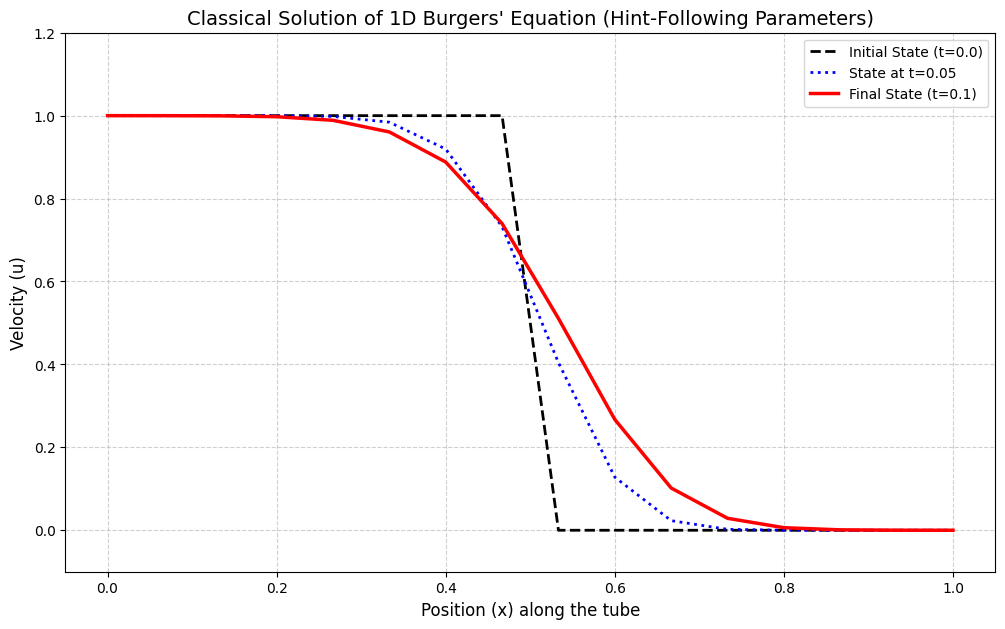

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

GRID_POINTS = 16                       # Coarse grid (from hint), maps to a 4-qubit system (16=2^4).
TOTAL_TIME = 0.1                          # Short-time integration (from hint) to keep circuit depth low later.
NU = 0.07                                 # Viscosity derived to match shock thickness to the coarse grid, ensuring a resolvable problem.
DT = 0.01                                 # Time step calculated to safely satisfy CFL stability conditions for the coarse grid.


# The domain is x in [0, 1] as specified in the problem statement
X_POINTS = np.linspace(0, 1, GRID_POINTS) # Array of x-coordinates
DX = X_POINTS[1] - X_POINTS[0]            # Distance between grid points
N_STEPS = int(TOTAL_TIME / DT)            # Total number of simulation steps


print(f"Grid Points: {GRID_POINTS} (for a 4-qubit system)")
print(f"Time Step (DT): {DT}")
print(f"Total Steps: {N_STEPS}")
print(f"Viscosity (NU): {NU}")
print(f"Grid Spacing (DX): {DX:.4f}")
print("-" * 26)


#  (RIEMANN STEP) ---

# This creates the sharp shockwave at t=0
u = np.zeros(GRID_POINTS)
u[:int(GRID_POINTS / 2)] = 1.0  # Left half of the tube has velocity 1
# The right half is already 0.0

# Keep a copy of the initial state for the final plot
u_initial = u.copy()



# store the state at each time step to visualize the evolution
u_history= [u_initial.copy()]

# Loop through time using tqdm for a progress bar
for _ in tqdm(range(N_STEPS), desc="Simulating"):
    u_current = u.copy()  # Get the current state

    # This loop applies the Burgers' equation to each internal point
    for i in range(1, GRID_POINTS - 1):
        # This is the "finite difference" implementation of the PDE:
        # du/dt = -u * du/dx + nu * d^2u/dx^2
        
        # Convection term: -u * du/dx
        advection = -u_current[i] * (u_current[i] - u_current[i-1]) / DX
        
        # Diffusion term: nu * d^2u/dx^2
        diffusion = NU * (u_current[i+1] - 2 * u_current[i] + u_current[i-1]) / DX**2
        
        # Update the velocity at point 'i' for the next time step
        u[i] = u_current[i] + (advection + diffusion) * DT
    
    # Store the result of this time step
    u_history.append(u.copy())

np.save('fd_solution.npy', u_history[-1])
plt.figure(figsize=(12, 7))

# Plot the state at a few different time points
plt.plot(X_POINTS, u_history[0], 'k--', label=f'Initial State (t=0.0)', linewidth=2)
# Show an intermediate step
intermediate_step = N_STEPS // 2
plt.plot(X_POINTS, u_history[intermediate_step], 'b:', label=f'State at t={intermediate_step*DT}', linewidth=2)
# Plot the final state
plt.plot(X_POINTS, u_history[-1], 'r-', label=f'Final State (t={TOTAL_TIME})', linewidth=2.5)

plt.ylim(-0.1, 1.2)
plt.xlabel('Position (x) along the tube', fontsize=12)
plt.ylabel('Velocity (u)', fontsize=12)
plt.title("Classical Solution of 1D Burgers' Equation (Hint-Following Parameters)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:


GRID_POINTS = N=16             # Coarse grid , maps to a 4-qubit system (16=2^4).
TOTAL_TIME = 0.1                          # Short-time integration to keep circuit depth low later.
NU = 0.07                                 # Viscosity derived to match shock thickness to the coarse grid, ensuring a resolvable problem.
DT = 0.01                                 # Time step calculated to safely satisfy CFL stability conditions for the coarse grid.
# The domain is x in [0, 1] 
X_POINTS = np.linspace(0, 1, GRID_POINTS) # Array of x-coordinates
DX = X_POINTS[1] - X_POINTS[0]            # Distance between grid points
N_STEPS = int(TOTAL_TIME / DT)            # Total number of simulation steps

# Initial condition (Riemann step)
u0 = np.zeros(N)
u0[:N//2] = 1.0
u0[0] = 1.0  # Boundary condition at x=0
u0[-1] = 0.0  # Boundary condition at x=1

In [19]:
#  Quasilinearization function( for jacobian matrix)
from scipy.linalg import solve

def compute_F(u, DX, NU, N):
    F = np.zeros(N)
    for i in range(1, N-1):
        advection = -u[i] * (u[i] - u[i-1]) / DX
        diffusion = NU * (u[i+1] - 2*u[i] + u[i-1]) / DX**2
        F[i] = advection + diffusion
    return F

def compute_J(u, DX, NU, N):
    J = np.zeros((N, N))
    for i in range(1, N-1):
        # Diffusion terms
        J[i, i-1] += NU / DX**2
        J[i, i] += -2 * NU / DX**2
        J[i, i+1] += NU / DX**2
        # Advection terms (linearized)
        J[i, i] += -(2 * u[i] - u[i-1]) / DX
        J[i, i-1] += u[i] / DX
    # Boundaries (Dirichlet)
    J[0, 0] = 1.0
    J[N-1, N-1] = 1.0
    return J


In [20]:

def vector_to_mps(vec, n_qubits, max_bond=64):
   
    N = len(vec)
    dim = 2**n_qubits
    
    # Ensure we have enough dimensions
    if N > dim:
        raise ValueError(f"Vector length {N} exceeds 2^{n_qubits} = {dim}")
    
    # Pad vector to power of 2 length
    padded_vec = np.zeros(dim, dtype=complex)
    padded_vec[:N] = vec.astype(complex)
    
    # Reshape to multi-dimensional tensor: [2, 2, 2, 2]
    tensor_shape = [2] * n_qubits
    tensor = padded_vec.reshape(tensor_shape)
    
    
    mps = qtn.MatrixProductState.from_dense(
        tensor, 
        max_bond=max_bond,
        cutoff=1e-12,
        method='svd'
    )
    
    return mps

def mps_to_vector(mps, N):
  
    dense_tensor = mps.to_dense()
    
    # Flatten the multi-dimensional tensor back to 1D
    full_vector = dense_tensor.flatten()
    
    # Return only the first N elements (remove padding)
    return full_vector[:N].real

def create_diffusion_mpo(N, dt, dx, nu, n_qubits, max_bond=64):
    
    # Create the diffusion matrix
    D = np.zeros((N, N), dtype=complex)
    
    # Interior points: second derivative discretization
    for i in range(1, N-1):
        D[i, i-1] = nu / dx**2
        D[i, i] = -2 * nu / dx**2  
        D[i, i+1] = nu / dx**2
    
    # Boundary conditions (Dirichlet)
    D[0, 0] = 1.0
    D[-1, -1] = 1.0
    
    # Create time evolution operator: exp(D * dt)
    from scipy.linalg import expm
    evolution_matrix = expm(D * dt)
    
    # Pad to power-of-2 dimensions
    dim = 2**n_qubits
    padded_matrix = np.eye(dim, dtype=complex)
    padded_matrix[:N, :N] = evolution_matrix
    
    # Reshape for MPO: [2,2,2,2] ⊗ [2,2,2,2] = [2,2,2,2,2,2,2,2]
    mpo_shape = [2] * (2 * n_qubits)
    mpo_tensor = padded_matrix.reshape(mpo_shape)
    
   
    mpo = qtn.MatrixProductOperator.from_dense(
        mpo_tensor,
        max_bond=max_bond,
        cutoff=1e-12,
        method='svd'
    )
    
    return mpo


In [21]:


N=GRID_POINTS
n_qubits=4
MAX_BOND=16
u_history_classical = [u_initial.copy()]
# Create diffusion operator MPO for time evolution
def create_diffusion_mpo(dt, dx, nu, n_qubits):
    """Create diffusion operator MPO for time evolution e^(D*dt)
    
    This is valid because diffusion is a linear operator.
    """
    # Create diffusion operator matrix
    D = np.zeros((N, N), dtype=complex)
    for i in range(1, N-1):
        D[i, i-1] = nu / dx**2
        D[i, i] = -2 * nu / dx**2
        D[i, i+1] = nu / dx**2
    
    # Apply boundary conditions
    D[0, :] = 0.0
    D[0, 0] = 1.0
    D[-1, :] = 0.0
    D[-1, -1] = 1.0
    
    # Create time evolution operator for diffusion: e^(D*dt)
    diffusion_op = expm(D * dt)
    
    # Pad to power of 2 dimensions
    dim = 2**n_qubits
    padded_op = np.zeros((dim, dim), dtype=complex)
    padded_op[:N, :N] = diffusion_op
    
    # Convert to MPO format
    tensor_shape = [2] * (2 * n_qubits)
    return qtn.MatrixProductOperator.from_dense(
        padded_op.reshape(tensor_shape),
        method='svd',
        max_bond=MAX_BOND,
        cutoff=1e-12
    )

def advection_step(u, dt, dx):
    """Solve the advection part using an upwind scheme
    
    This handles the nonlinear part of the Burgers equation.
    """
    u_next = u.copy()
    for i in range(1, N-1):
        # Upwind scheme for advection: -u * du/dx
        u_next[i] = u[i] - dt * u[i] * (u[i] - u[i-1]) / dx
    
    # Apply boundary conditions
    u_next[0] = 1.0
    u_next[-1] = 0.0
    
    return u_next

t_start_split = time()

# Create diffusion MPO (can be precomputed as it doesn't change)
diffusion_half_mpo = create_diffusion_mpo(DT/2, DX, NU, n_qubits)

# Initialize state as MPS
u_mps_split = vector_to_mps(u0, n_qubits)
u_split = u0.copy()
u_history_split = [u_split.copy()]

for step in range(N_STEPS):
    # Step 1: First half-step diffusion (linear part)
    u_mps_split = diffusion_half_mpo.apply(
        u_mps_split,
        compress=True,
        max_bond=MAX_BOND,
        cutoff=1e-12
    )
    
    # Extract state for advection step
    u_split = mps_to_vector(u_mps_split, N).real
    u_split[0] = 1.0  # Enforce BCs
    u_split[-1] = 0.0
    
    # Step 2: Full step advection (nonlinear part)
    u_split = advection_step(u_split, DT, DX)
    
    # Convert back to MPS for next diffusion step
    u_mps_split = vector_to_mps(u_split, n_qubits)
    
    # Step 3: Second half-step diffusion (linear part)
    u_mps_split = diffusion_half_mpo.apply(
        u_mps_split,
        compress=True,
        max_bond=MAX_BOND,
        cutoff=1e-12
    )
    
    # Extract final state and enforce BCs
    u_next = mps_to_vector(u_mps_split, N).real
    u_next[0] = 1.0
    u_next[-1] = 0.0
    
    # Update state and store history
    u_split = u_next
    u_history_split.append(u_split.copy())

t_end_split = time()
print(f"Time-Splitting MPO-TEBD solution done in {t_end_split - t_start_split:.4f} seconds")
np.save('mpo_split_solution.npy', u_history_split[-1])


final_diff_classical = np.linalg.norm(u_history_classical[-1] - u_history_split[-1])
print(f"L2 difference between classical and Time-Splitting solutions: {final_diff_classical:.6e}")


# Plot final solutions
plt.figure(figsize=(10, 6))
plt.plot(X_POINTS, u_history_classical[-1], 'b-', label='Classical')
#plt.plot(X_POINTS, u_history_mpo_tebd[-1], 'r--', label='Original MPO-TEBD')
plt.plot(X_POINTS, u_history_split[-1], 'g-', label='Time-Splitting MPO-TEBD')
plt.plot(X_POINTS, u0, 'k:', label='Initial')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Burgers Equation Solutions')
plt.legend()
plt.grid(True)
plt.savefig('burgers_time_splitting_comparison.png', dpi=300)
plt.close()

print("Comparison plot saved as 'burgers_time_splitting_comparison.png'")
print("Time-Splitting MPO-TEBD solution saved as 'mpo_split_solution.npy'")


Time-Splitting MPO-TEBD solution done in 0.0370 seconds
L2 difference between classical and Time-Splitting solutions: 6.446605e-01
Comparison plot saved as 'burgers_time_splitting_comparison.png'
Time-Splitting MPO-TEBD solution saved as 'mpo_split_solution.npy'


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# Run the Time-Splitting MPO-TEBD simulation
def run_time_splitting_simulation():
    """Run the full time-splitting MPO-TEBD simulation and return the history"""
    # Create diffusion MPO
    diffusion_half_mpo = create_diffusion_mpo(DT/2, DX, NU, n_qubits)
    
    # Initialize state as MPS
    u_mps_split = vector_to_mps(u0, n_qubits)
    u_split = u0.copy()
    u_history = [u_split.copy()]
    
    for step in range(N_STEPS):
        # Step 1: First half-step diffusion (linear part)
        u_mps_split = diffusion_half_mpo.apply(
            u_mps_split,
            compress=True,
            max_bond=MAX_BOND,
            cutoff=1e-12
        )
        
        # Extract state for advection step
        u_split = mps_to_vector(u_mps_split, N).real
        u_split[0] = 1.0  # Enforce BCs
        u_split[-1] = 0.0
        
        # Step 2: Full step advection (nonlinear part)
        u_split = advection_step(u_split, DT, DX)
        
        # Convert back to MPS for next diffusion step
        u_mps_split = vector_to_mps(u_split, n_qubits)
        
        # Step 3: Second half-step diffusion (linear part)
        u_mps_split = diffusion_half_mpo.apply(
            u_mps_split,
            compress=True,
            max_bond=MAX_BOND,
            cutoff=1e-12
        )
        
        # Extract final state and enforce BCs
        u_next = mps_to_vector(u_mps_split, N).real
        u_next[0] = 1.0
        u_next[-1] = 0.0
        
        # Update state and store history
        u_split = u_next
        u_history.append(u_split.copy())
    
    return u_history

try:
    # Load the classical solution history
    classical_history = u_history_classical
    
    # Run the Time-Splitting MPO-TEBD simulation
    print("Running full Time-Splitting MPO-TEBD simulation for animation...")
    split_history = run_time_splitting_simulation()
    
    # Create animation
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot initial state
    classical_line, = ax.plot(X_POINTS, classical_history[0], 'b-', label='Classical')
    split_line, = ax.plot(X_POINTS, split_history[0], 'r--', label='Time-Splitting MPO-TEBD')
    
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title('Burgers Equation Time Evolution')
    ax.set_ylim(-0.1, 1.2)
    ax.grid(True)
    ax.legend()
    
    time_text = ax.text(0.02, 0.95, f'Time: 0.00', transform=ax.transAxes)
    
    def update(frame):
        classical_line.set_ydata(classical_history[frame])
        split_line.set_ydata(split_history[frame])
        time_text.set_text(f'Time: {frame*DT:.2f}')
        return classical_line, split_line, time_text
    
    
    
    plt.close()
    
    
    # Also create a plot showing the initial and final states
    plt.figure(figsize=(10, 6))
    plt.plot(X_POINTS, u0, 'k--', label='Initial (t=0)')
    plt.plot(X_POINTS, classical_history[-1], 'b-', label=f'Classical (t={TOTAL_TIME})')
    plt.plot(X_POINTS, split_history[-1], 'r--', label=f'Time-Splitting MPO-TEBD (t={TOTAL_TIME})')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Burgers Equation Initial and Final States')
    plt.legend()
    plt.grid(True)
    plt.savefig('burgers_initial_final_split.png', dpi=300)
    plt.close()
    
    print("Initial and final state plot saved as 'burgers_initial_final_split.png'")
    
except Exception as e:
    print(f"Error in visualization: {str(e)}")
    print("Make sure to run the previous cells first.")


Running full Time-Splitting MPO-TEBD simulation for animation...
Initial and final state plot saved as 'burgers_initial_final_split.png'


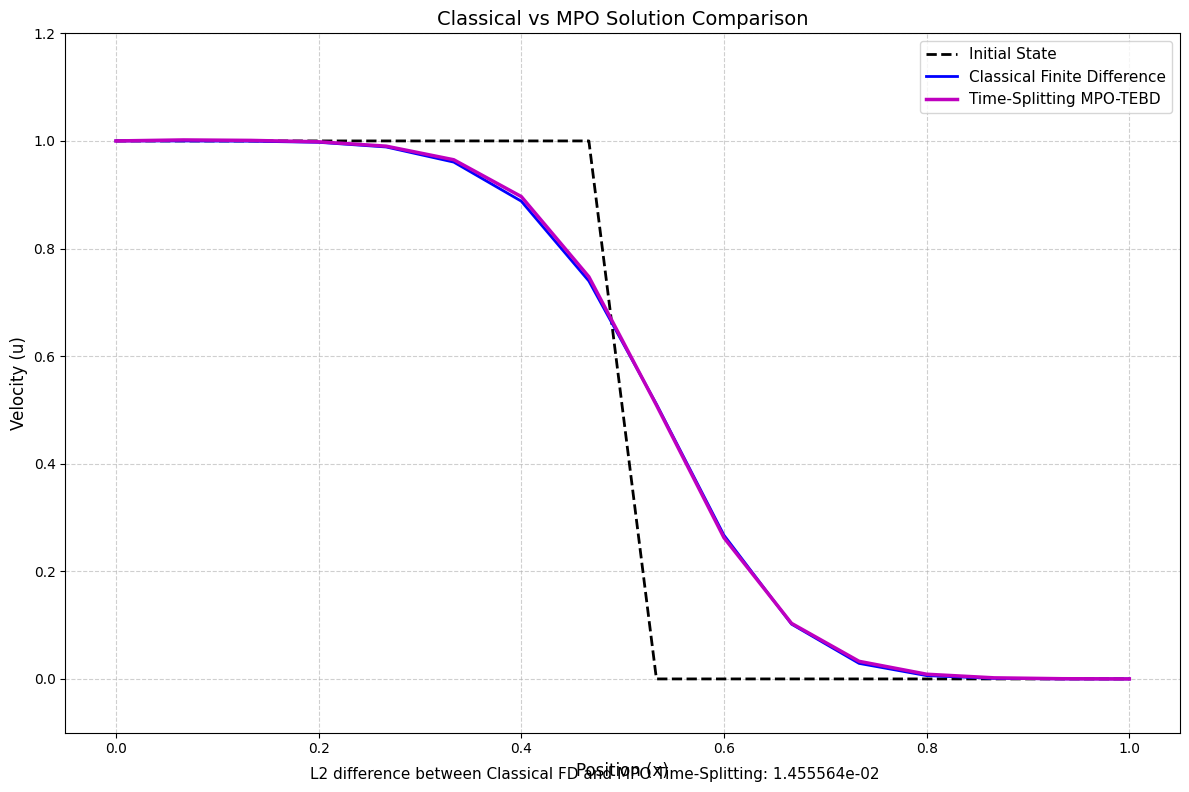

Classical FD solution range: [0.0000, 1.0000]
Classical FD solution L2 norm: 2.7520

MPO Time-Splitting solution range: [0.0000, 1.0019]
MPO Time-Splitting solution L2 norm: 2.7598

L2 difference between methods: 1.455564e-02
Relative L2 error: 5.289125e-03 (0.5289%)


In [23]:

try:
    # Load the two solutions we want to compare
    classical_final = np.load('fd_solution.npy')  # Your classical finite difference solution
    mpo_split_final = np.load('mpo_split_solution.npy')  # MPO time-splitting solution
    
    # Create comparison plot
    plt.figure(figsize=(12, 8))
    plt.plot(X_POINTS, u_initial, 'k--', label='Initial State', linewidth=2)
    plt.plot(X_POINTS, classical_final, 'b-', label='Classical Finite Difference', linewidth=2)
    plt.plot(X_POINTS, mpo_split_final, 'm-', label='Time-Splitting MPO-TEBD', linewidth=2.5)
    
    plt.xlabel('Position (x)', fontsize=12)
    plt.ylabel('Velocity (u)', fontsize=12)
    plt.title('Classical vs MPO Solution Comparison', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(-0.1, 1.2)
    
    # Calculate and display difference
    l2_diff = np.linalg.norm(classical_final - mpo_split_final)
    info_text = f"L2 difference between Classical FD and MPO Time-Splitting: {l2_diff:.6e}"
    plt.figtext(0.5, 0.02, info_text, ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('classical_vs_mpo_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Classical FD solution range: [{np.min(classical_final):.4f}, {np.max(classical_final):.4f}]")
    print(f"Classical FD solution L2 norm: {np.linalg.norm(classical_final):.4f}")
    print()
    print(f"MPO Time-Splitting solution range: [{np.min(mpo_split_final):.4f}, {np.max(mpo_split_final):.4f}]")
    print(f"MPO Time-Splitting solution L2 norm: {np.linalg.norm(mpo_split_final):.4f}")
    print()
    print(f"L2 difference between methods: {l2_diff:.6e}")
    
    # Calculate relative error
    relative_error = l2_diff / np.linalg.norm(classical_final)
    print(f"Relative L2 error: {relative_error:.6e} ({relative_error*100:.4f}%)")
    
    
except FileNotFoundError as e:
    missing_file = str(e).split("'")[1]
    print(f"Error: Could not find file '{missing_file}'")
    
except Exception as e:
    print(f"Error in comparison: {str(e)}")
    print("Check that both solution files exist and contain valid numpy arrays")